In [1]:
# 부스팅 알고리즘 / knn 알고리즘을 이용하여 공모전 참여해보기
# 에이다부스팅/ 그레디언트 부스팅을 테스트 해보자. 
# 이걸 가지고 공모전에 참여해서 의미있는 점수를 내보자. 
# 케글에 Bike Sharing Demand가 있다. 한국의 따릉이처럼 자전거를 대여하는 시스템이다.
# 시간에 따른 워싱턴의 자전거 대여량을 확인하는 것이다. 키오스크를 통해 직접 대여를 하는 식이다. 
# 예상되는 대여량을 수식으로 나타낸다. 
# 평가방법은 제출을 할 때 애러가 의미하는 것은 예측값과 실제값과의 차이이다. 애러를 구할 때 제곱한 이후 로그를 취해서 구했다.
# 예측값에 실제값을 빼고 제곱한 이후 루트를 했다. 오차값을 절대값으로 보는 것이다. 
# 결론적으로 저 수치값이 작아야 한다. 그것을 최소로 하는 것이 목표인 것이다. 
# 1000등안에 드는 것을 목표로 해보자. 

In [2]:
# datetime - 시간별 날짜 + 타임스탬프  
# 계절 - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울 
# 휴일 - 해당 날짜가 휴일로 간주되는지 여부
# 근무일 - 해당 날짜가 주말이나 휴일이 아닌지 여부
# 날씨 - 1: 맑음, 거의 없음 구름, 약간 흐림, 약간 흐림
# 2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간의 구름, 안개
# 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
# 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개 
# 온도 - 섭씨 온도
# atemp - 체감온도(섭씨)
# 습도 - 상대 습도
# 풍속 - 풍속
# 일반 - 시작된 미등록 사용자 대여 수
# 등록됨 - 등록된 사용자 대여 시작 수
# 카운트 - 숫자 총 임대료 대비
# 이와같은 옵션들을 지니고 있다. 
# 테스트 파일에는 카운트 관련 변수가 아무것도 적혀있지 않을 것이다. 이것을 채우는 것이 우리의 목표이다. 
# 현재는 랜덤 포레스트를 통한 등수올리기를 중점적으로 하고자 한다.

In [3]:
# 계획단계
# 같이 제출해보고 등수를 올리기 위한 다양한 노력을 해보자. 
# 1. 필요한 데이터를 확인한다. 그리고 데이터의 구조를 확인한다.
# 2. 데이터 전처리 과정이 중요하다. 그리고 시각화를 한다. 
# 3. 회귀모델을 만들고 결론을 도출하는 것까지 한다. 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar # 사실 이걸 임포트 한 이유는 여기에 있는 속성을 사용하기 위함이다. 
from datetime import datetime

In [73]:
# 1단계. 필요한 모듈과 데이터를 불러온다. 
train = pd.read_csv("bike-sharing-demand/train.csv") # 트레인을 불러왔다. 
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [74]:
test = pd.read_csv("bike-sharing-demand/test.csv") # 테스트를 불러왔다. 
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [75]:
# 2단계. 데이터의 모양과 결측값과 형식을 본다.
train.info()
# 날짜가 문자로 되어있다. 날짜관련 함수를 적용하기 위해서 저렇게 된 듯 하다. 
# 문자로 쓴다면 스플릿을 쓰면 될 듯 하다. 위에도 띄어쓰기로 시간과 구분이 될 수 있다.
# 다행인 점은 결측값이 존재하지 않는다. 
# 데이트 타임의 데이터는 연/월/일이다. 날짜는 '-'로 묶여있고 공백이 있고 시분초는 ":"로 묶여있다. 
# 년월일을 각각 추출해보자. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [76]:
# 나는 이런 식으로 분리해냈다. 
year = train['datetime'].map(lambda x : x.split(' ')[0].split('-')[0])
month = train['datetime'].map(lambda x : x.split(' ')[0].split('-')[1])
day = train['datetime'].map(lambda x : x.split(' ')[0].split('-')[2])
hour = train['datetime'].map(lambda x : x.split(' ')[1].split(':')[0])
# 다른 사람이 어떻게 했는지 보자. 
# train.datetime.astype('datetime64').dt.year 이런 식으로 날짜처리를 한것이다. 데이트타임과 관련된 함수를 적용할 수 있게 만든것이다. 
# 즉 타입이 데이트타임이면 연월일을 따로 추출하는 방식이다. 매우 좋은 코드이다. 
# year = train["datetime"].str.split("-").str[0] # 내가 실수했던 것은 str을 적용하지 않은 것이다. str은  단위로 적용된다는 뜻이다. 
# 즉 str활용을 정확히 알아보자. 그냥 [0]을 하면 행 단위로 추출되지만 str[0]을 하면 열 단위로 추출한다. 

In [77]:
# 팁. 데이트타임 설정하기
df = pd.read_csv("bike-sharing-demand/train.csv",parse_dates=['datetime']) 
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [78]:
df.info()#데이트타임 칸이 오브젝트가 아니라 데이트타임(나노세컨드)로 나올 것이다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [79]:
df['datetime'].dt.year #연도만 나온다. 여기서 dt.month, dt.day, dt.hour, dt.minute 와도 같이 추출이 가능하다. 
# 날짜함수를 적용할 수 있어서 간단하게 날짜함수를 적용할 수 있다. 
# https://datascienceschool.net/01%20python/04.08%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%9E%90%EB%A3%8C%20%EB%8B%A4%EB%A3%A8%EA%B8%B0.html
# 여기서 dt접근자에 대한 설명이 나온다. 


0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [80]:
train.datetime # 아무 옵션도 주지 않으면 오브젝트이다. 

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [81]:
train['tempdate'] = train.datetime.apply(lambda x:x.split())
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempdate
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,"[2011-01-01, 00:00:00]"
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,"[2011-01-01, 01:00:00]"
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,"[2011-01-01, 02:00:00]"
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,"[2011-01-01, 03:00:00]"
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,"[2011-01-01, 04:00:00]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,"[2012-12-19, 19:00:00]"
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,"[2012-12-19, 20:00:00]"
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,"[2012-12-19, 21:00:00]"
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,"[2012-12-19, 22:00:00]"


In [82]:
train['tempdate'] # 이제 나눠졌다. 

0        [2011-01-01, 00:00:00]
1        [2011-01-01, 01:00:00]
2        [2011-01-01, 02:00:00]
3        [2011-01-01, 03:00:00]
4        [2011-01-01, 04:00:00]
                  ...          
10881    [2012-12-19, 19:00:00]
10882    [2012-12-19, 20:00:00]
10883    [2012-12-19, 21:00:00]
10884    [2012-12-19, 22:00:00]
10885    [2012-12-19, 23:00:00]
Name: tempdate, Length: 10886, dtype: object

In [83]:
train['year'] = train.tempdate.apply(lambda x : x[0].split("-")[0])
train['month'] = train.tempdate.apply(lambda x : x[0].split("-")[1])
train['day'] = train.tempdate.apply(lambda x : x[0].split("-")[2])
train['hour'] = train.tempdate.apply(lambda x : x[1].split(":")[0])
train
# 시간 데이터를 나누었다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempdate,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,"[2011-01-01, 00:00:00]",2011,01,01,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,"[2011-01-01, 01:00:00]",2011,01,01,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,"[2011-01-01, 02:00:00]",2011,01,01,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,"[2011-01-01, 03:00:00]",2011,01,01,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,"[2011-01-01, 04:00:00]",2011,01,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,"[2012-12-19, 19:00:00]",2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,"[2012-12-19, 20:00:00]",2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,"[2012-12-19, 21:00:00]",2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,"[2012-12-19, 22:00:00]",2012,12,19,22


In [84]:
# 캘린더 속성을 몇개 활용해보자.
list(calendar.day_name) # 요일이 출력되었다. 

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [85]:
list(calendar.day_abbr)# 축약형을 추출하였다.

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [86]:
calendar.day_name[1] # 단순하게 출력도 가능하다.

'Tuesday'

In [87]:
import locale# 위치설정 임포트이다.  
locale.setlocale(locale.LC_ALL,'korean')# 로케일을 한국으로 설정했다. 

'Korean_Korea.949'

In [88]:
list(calendar.day_name)# 상당히 재밌게도 한글로 바뀌었다. 

['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

In [89]:
locale.setlocale(locale.LC_ALL,'de_DE')#로케일을 독일로 바꿔보았다. 

'de_DE'

In [90]:
list(calendar.day_name) # 독일어로 나왔다. 캘린더 모듈과 더불어서 사용이 가능한 것이다. 

['Montag',
 'Dienstag',
 'Mittwoch',
 'Donnerstag',
 'Freitag',
 'Samstag',
 'Sonntag']

In [91]:
locale.setlocale(locale.LC_ALL,'english')

'English_United States.1252'

In [92]:
# 데이트타임 사용 설명서
# 파이썬에서 데이트타임에 대한 설명은 https://docs.python.org/3/library/datetime.html#available-types에 있다. 
datetime.today() # 날짜는 다음과 같이 표시할 수 있다.

datetime.datetime(2023, 10, 20, 12, 20, 56, 748218)

In [93]:
s = pd.Series(pd.date_range("2020-12-25", periods=100, freq="D"))
s # 2020년 12월 25일 기준으로 100일에 해당하는 날짜를 설명해준다. 
# 기념일 챙기기 달력으로 좋네

0    2020-12-25
1    2020-12-26
2    2020-12-27
3    2020-12-28
4    2020-12-29
        ...    
95   2021-03-30
96   2021-03-31
97   2021-04-01
98   2021-04-02
99   2021-04-03
Length: 100, dtype: datetime64[ns]

In [94]:
s.dt.year

0     2020
1     2020
2     2020
3     2020
4     2020
      ... 
95    2021
96    2021
97    2021
98    2021
99    2021
Length: 100, dtype: int64

In [95]:
s.dt.strftime("%Y년 %m월 %d일")# 날짜형식이 문자열로 바뀌면서 년월일이 붙었다.

0     2020-12-25 00:00:00
1     2020-12-26 00:00:00
2     2020-12-27 00:00:00
3     2020-12-28 00:00:00
4     2020-12-29 00:00:00
             ...         
95    2021-03-30 00:00:00
96    2021-03-31 00:00:00
97    2021-04-01 00:00:00
98    2021-04-02 00:00:00
99    2021-04-03 00:00:00
Length: 100, dtype: object

In [96]:
# 이것과 반대되는 속성이 있다. 문자형을 날짜형식으로 바꿔주는 것이다
datetime.strptime("202310201053","%Y%m%d%H%M") # 이처럼 날짜를 바꿔준다. 
# %Y : 4자리 수 year
# %y : 2자리 수 year
# %m : 2자리 수 month (1~9월의 경우, 앞에 0을 채운다)
# %d : 2자리 수 date (1~9일의 경우, 앞에 0을 채운다)
# %H : 2자리 수 시간 (24-hour clock, 0~9시의 경우, 앞에 0을 채운다)
# %M : 2자리 수 분 (0~9분의 경우, 앞에 0을 채운다)
# %S : 2자리 수 초 (0~9초의 경우, 앞에 0을 채운다)

datetime.datetime(2023, 10, 20, 10, 53)

In [97]:
# 문자열을 숫자로 바꾸는 방법은 여러가지이다.
train['year']= pd.to_numeric(train.year)
train['month']= pd.to_numeric(train.month)
train['day']= pd.to_numeric(train.day)
train['hour']= pd.to_numeric(train.hour)
# 이런 식으로 일괄적으로 숫자로 저장했다. 

In [98]:
train.tempdate # 여기있는 날짜가 무슨요일인지 궁금할 것이다. 
# weekday정보를 통해 해당요일에 대한 정보를 알 수 있다. 

0        [2011-01-01, 00:00:00]
1        [2011-01-01, 01:00:00]
2        [2011-01-01, 02:00:00]
3        [2011-01-01, 03:00:00]
4        [2011-01-01, 04:00:00]
                  ...          
10881    [2012-12-19, 19:00:00]
10882    [2012-12-19, 20:00:00]
10883    [2012-12-19, 21:00:00]
10884    [2012-12-19, 22:00:00]
10885    [2012-12-19, 23:00:00]
Name: tempdate, Length: 10886, dtype: object

In [99]:
s = pd.Series(pd.date_range("2023-10-20", periods=10, freq="D"))
s.dt.weekday# 함수가 아닌 속성이라 괄호가 없으면 작동된다. 요일정보가 잘 나온다. 월요일이 0인 모양이다.

0    4
1    5
2    6
3    0
4    1
5    2
6    3
7    4
8    5
9    6
dtype: int64

In [100]:
# 유용한 코드
list(calendar.day_name)[s.dt.weekday.iloc[0]] # 해당 날짜를 이런 식으로 바로 추출이 된다. 

'Friday'

In [101]:
train.tempdate.apply(lambda x :x[0]) # 하필 오브젝트이다. 데이트타임 형으로 읽어야 하는데 이거 오브젝트이다. 
# 지금은 고생해야햔다. 오브젝트를 타임프레임으로 바꾸어야 한다. 
# strptime을 사용해서 바꾸면 된다. 

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: tempdate, Length: 10886, dtype: object

In [86]:
# train= train.tempdate.apply(lambda x :datetime.strptime(x[0],"%Y-%m-%d")) 

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
10881   2012-12-19
10882   2012-12-19
10883   2012-12-19
10884   2012-12-19
10885   2012-12-19
Name: tempdate, Length: 10886, dtype: datetime64[ns]

In [102]:
train.tempdate.apply(lambda x: datetime.strptime(x[0],"%Y-%m-%d").weekday()) # 바로 날짜숫자를 추출했다. 

0        5
1        5
2        5
3        5
4        5
        ..
10881    2
10882    2
10883    2
10884    2
10885    2
Name: tempdate, Length: 10886, dtype: int64

In [103]:
train.tempdate.apply(lambda x: calendar.day_name[datetime.strptime(x[0],"%Y-%m-%d").weekday()]) # 영어로 바꾸었다. 

0         Saturday
1         Saturday
2         Saturday
3         Saturday
4         Saturday
           ...    
10881    Wednesday
10882    Wednesday
10883    Wednesday
10884    Wednesday
10885    Wednesday
Name: tempdate, Length: 10886, dtype: object

In [104]:
train['weekday']=train.tempdate.apply(lambda x: calendar.day_name[datetime.strptime(x[0],"%Y-%m-%d").weekday()]) # 이걸 바꿔보자. 
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempdate,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,"[2011-01-01, 00:00:00]",2011,1,1,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,"[2011-01-01, 01:00:00]",2011,1,1,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,"[2011-01-01, 02:00:00]",2011,1,1,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,"[2011-01-01, 03:00:00]",2011,1,1,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,"[2011-01-01, 04:00:00]",2011,1,1,4,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,"[2012-12-19, 19:00:00]",2012,12,19,19,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,"[2012-12-19, 20:00:00]",2012,12,19,20,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,"[2012-12-19, 21:00:00]",2012,12,19,21,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,"[2012-12-19, 22:00:00]",2012,12,19,22,Wednesday


In [105]:
train['hour']=pd.to_numeric(train.hour)# 오브젝트를 인티저로 바꾸자. 
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempdate,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,"[2011-01-01, 00:00:00]",2011,1,1,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,"[2011-01-01, 01:00:00]",2011,1,1,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,"[2011-01-01, 02:00:00]",2011,1,1,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,"[2011-01-01, 03:00:00]",2011,1,1,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,"[2011-01-01, 04:00:00]",2011,1,1,4,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,"[2012-12-19, 19:00:00]",2012,12,19,19,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,"[2012-12-19, 20:00:00]",2012,12,19,20,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,"[2012-12-19, 21:00:00]",2012,12,19,21,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,"[2012-12-19, 22:00:00]",2012,12,19,22,Wednesday


In [106]:
train = train.drop('tempdate',axis=1) # 필요없어진 tempdate를 드랍하자. 

In [107]:
train 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,Wednesday


In [108]:
# 분석에 앞서 시각화를 해보자. 
train.year.value_counts()# 2011년과 2012년의 자전거 저장셋이다. 

2012    5464
2011    5422
Name: year, dtype: int64

In [109]:
train.month.value_counts() # 월별 숫자이다. 

5     912
6     912
7     912
8     912
12    912
10    911
11    911
4     909
9     909
2     901
3     901
1     884
Name: month, dtype: int64

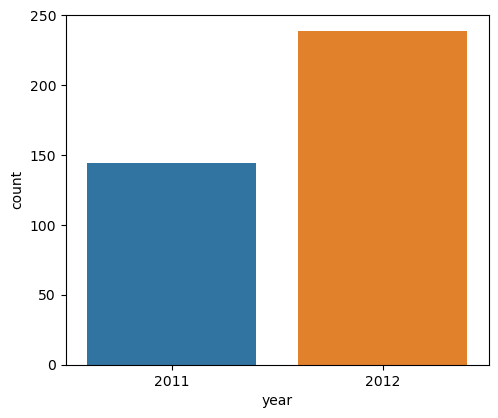

In [110]:
fig=plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)# 도화지는 두줄두칸왼쪽상단 첫번째칸으로 설정했다. 즉 4칸의 도화지를 만들었고 그 중 첫번째이다. 
ax1 = sns.barplot(x='year',y='count',data=train.groupby('year')['count'].mean().reset_index())# 작동이 안되서 리셋 인덱스를 사용했다. 

In [111]:
train.groupby('year')['count'].mean()#연도별 자전거 대여 평균수이다. 

year
2011    144.223349
2012    238.560944
Name: count, dtype: float64

In [112]:
train.groupby('year')['count'].mean().reset_index()#리셋 인덱스로 평균을 냈다. 즉 인덱스를 2011을 사용하지 않고 데이터화 시켰다. 

,year,count
0,2011,144.223349
1,2012,238.560944


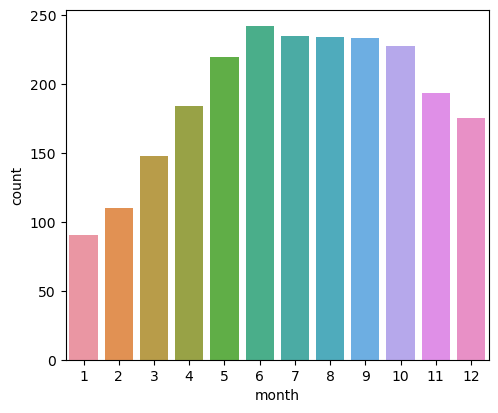

In [113]:
fig=plt.figure(figsize=[12,10])
ax2 = fig.add_subplot(2,2,2) # 4칸의 도화지  중 두번째이다. 
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())# 이제는 월 단위로 평균이용건수가 나온다. 

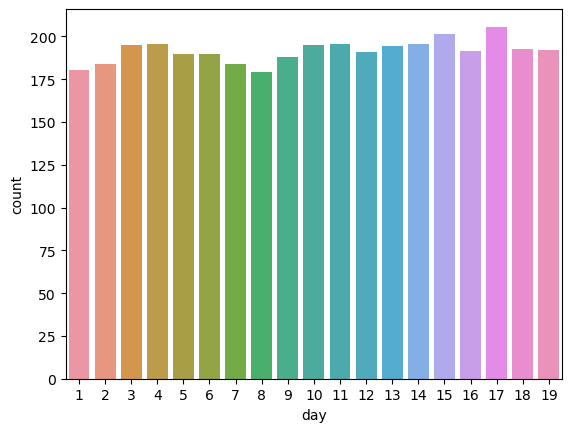

In [114]:
ax3 = fig.add_subplot(2,2,3) # 4칸의 도화지  중 세번째이다. 
ax3 = sns.barplot(x='day',y='count',data=train.groupby('day')['count'].mean().reset_index())# 일 단위 평균이용건수

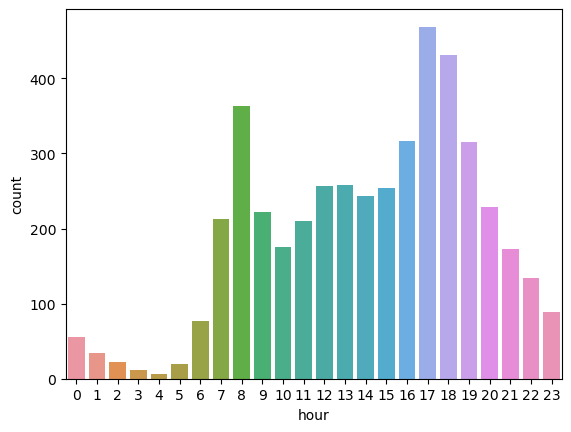

In [115]:
ax4 = fig.add_subplot(2,2,4)# 4칸의 도화지  중 네번째이다. 
ax4 = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index())# 시간단위 평균이용건수

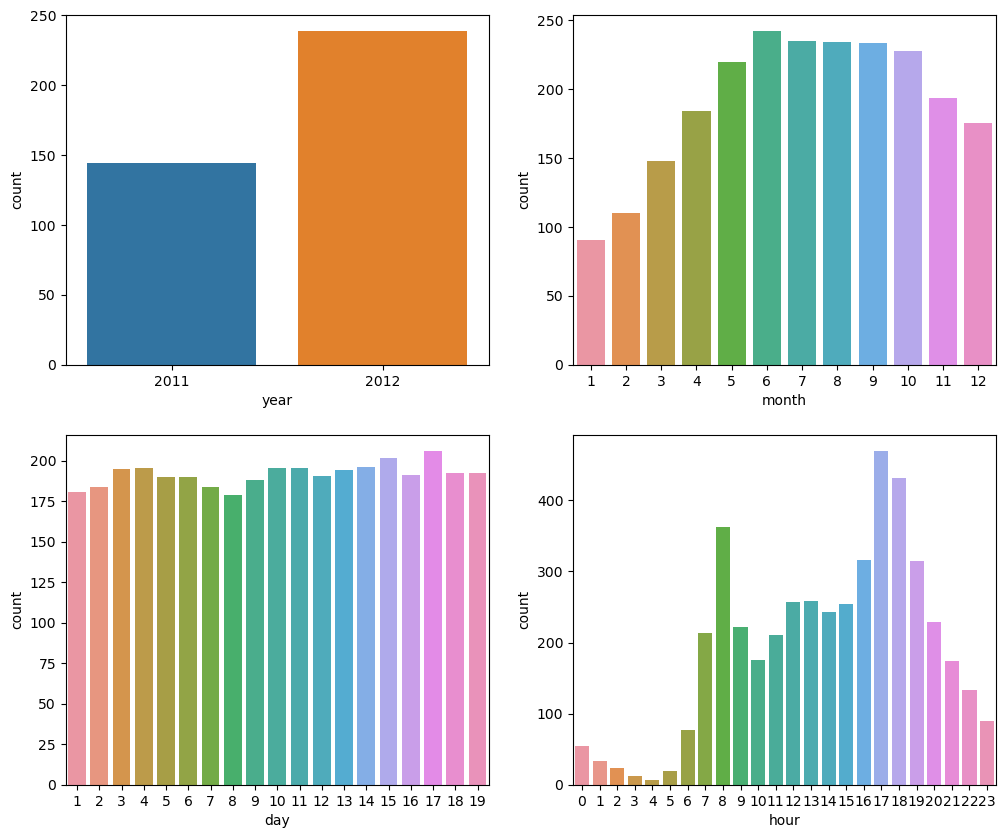

In [116]:
fig=plt.figure(figsize=[12,10]) 
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='count',data=train.groupby('year')['count'].mean().reset_index())
ax2 = fig.add_subplot(2,2,2) 
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='count',data=train.groupby('day')['count'].mean().reset_index())
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index())
# 모든 칸을 보여줄 수 있다. 

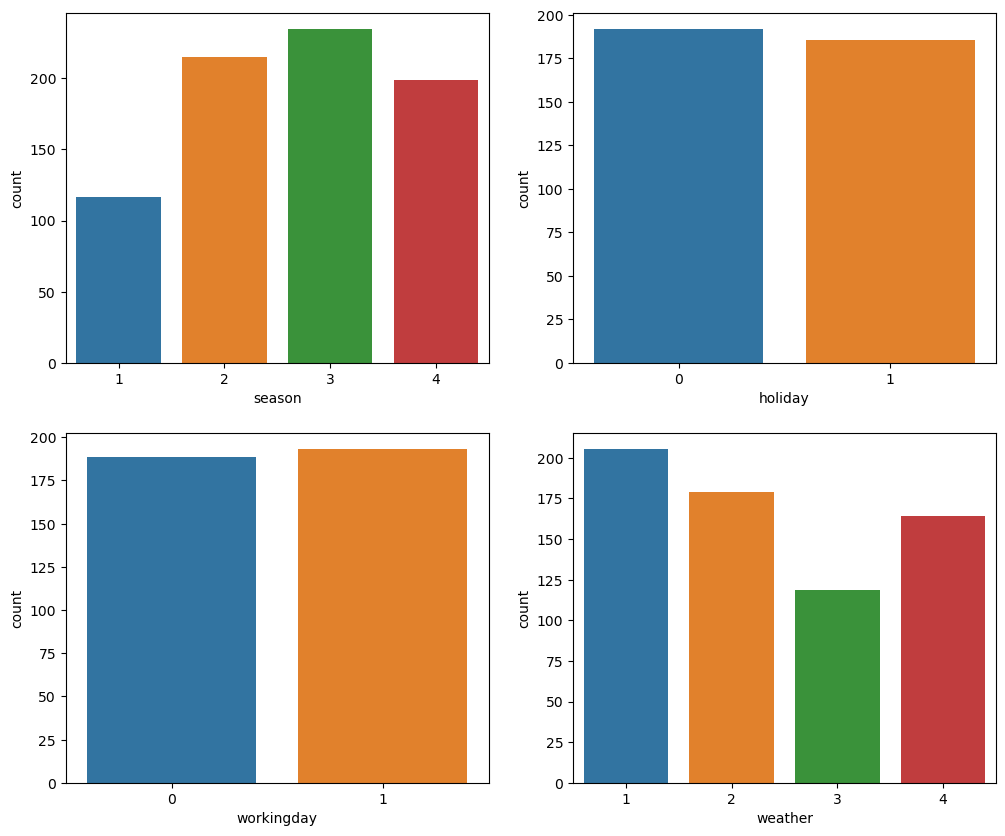

In [117]:
fig=plt.figure(figsize=[12,10]) 
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())
ax2 = fig.add_subplot(2,2,2) 
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())
# 매우 간단하게 코드를 바꿔서 시즌, 워킹데이, 홀리데이, 계절을 확인할 수 있었다. 
# 날씨가 좋지않으면 떨어지는 경향이 있다. 

In [119]:
train.head() # 시즌은 봄을 나타낸다. 사실 계절이라고 하기에는 애매하다. 시즌을 수정하는 것이 좋을 것이다. 
# 즉 12월달부터 2월을 겨울로, 3월부터 5월까지 봄으로 변경을 하는 것이 필요하다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,Saturday


In [121]:
train.month
train.season # 봄을 1로, 겨울을 4로 설정해보자. 
# 방법은 많다. 여기서는 함수를 써보자.

0        1
1        1
2        1
3        1
4        1
        ..
10881    4
10882    4
10883    4
10884    4
10885    4
Name: season, Length: 10886, dtype: int64

In [122]:
def newSeason(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

In [123]:
train['season'] = train.month.apply(newSeason)# month를 함수로 넘긴다. 
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,Saturday
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,Saturday
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,Saturday
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,Saturday
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,Wednesday


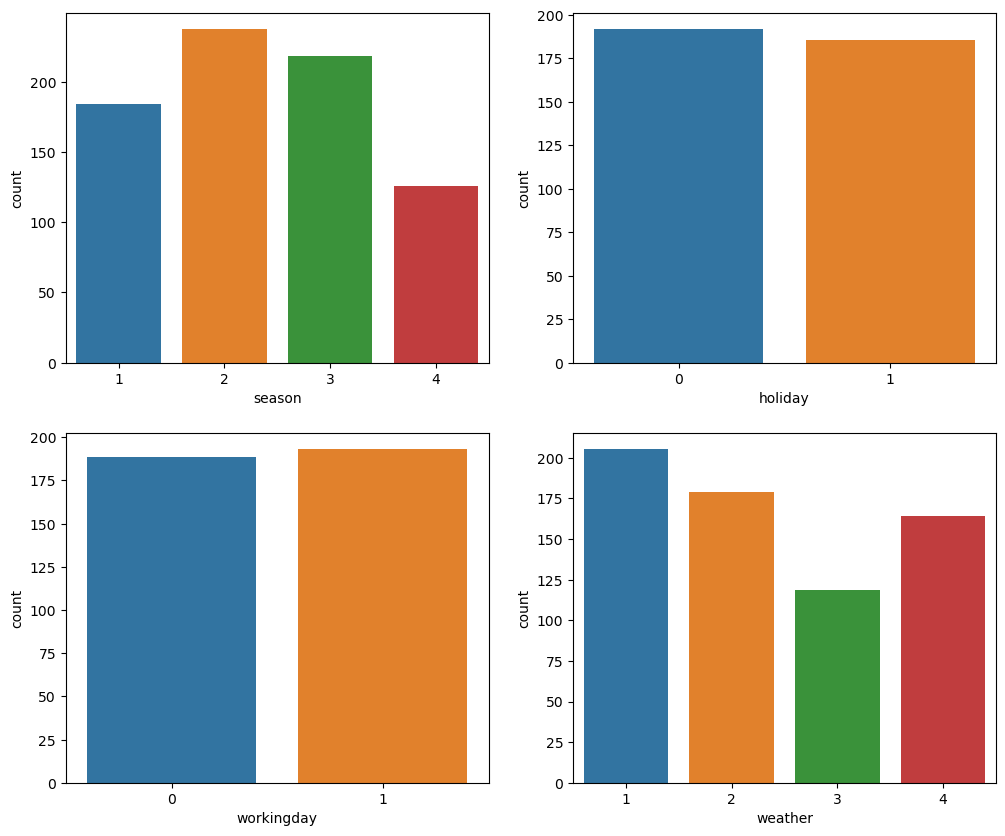

In [124]:
fig=plt.figure(figsize=[12,10]) 
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())
ax2 = fig.add_subplot(2,2,2) 
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())
# 이제야 겨울 이용자가 적어 보인다. 
# 원하는 방식으로 데이터를 바꾸게 되었다. 

C:\Users\user\AppData\Local\Temp\ipykernel_3040\2086291599.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(train.temp,bins=range(int(train.temp.min()),int(train.temp.max())+1))
C:\Users\user\AppData\Local\Temp\ipykernel_3040\2086291599.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.d

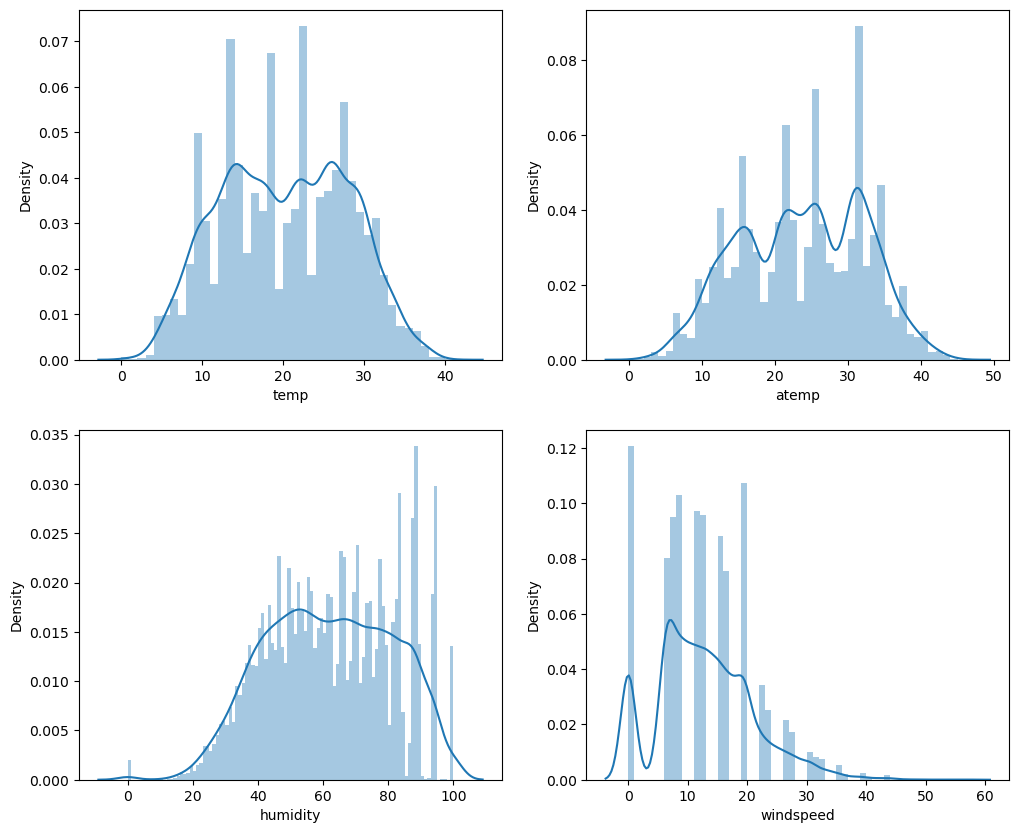

In [136]:
#온도와 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.distplot(train.temp,bins=range(int(train.temp.min()),int(train.temp.max())+1))
#체감온도와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.distplot(train.atemp,bins=range(int(train.atemp.min()),int(train.atemp.max())+1))

#습도와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.distplot(train.humidity,bins=range(int(train.humidity.min()),int(train.humidity.max())+1))

#바람속도와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.distplot(train.windspeed,bins=range(int(train.windspeed.min()),int(train.windspeed.max())+1))
# 구간별로 다음과 깉이 표시가 되었다. 온도, 체감온도, 습도, 풍속과의 관계를 확인할 수 있다. 


In [138]:
# 문제가 windspeed열을 보면 0이 나온다. 이것은 결측값으로 보인다. 즉 다른 값으로 대체를 해야 할 것이다. 
# 계절별로 windspeed 평균을 구해서 변경하는 것은 어떨까? 
# 이전에 배운 알고리즘을 보고 채워넣는 것이다. 즉 이번 자료는 풍속의 결측값을 채워야 한다. 
train.corr()
# 상관분석을 해보자. 

C:\Users\user\AppData\Local\Temp\ipykernel_3040\122028873.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
season,1.000000,0.041326,-0.029800,0.023406,-0.434241,-0.433335,0.042525,-0.052774,-0.212438,-0.072191,-0.118785,0.002976,0.201633,-0.001109,0.003424
holiday,0.041326,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.029800,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,0.023406,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
temp,-0.434241,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.015551,0.145430
atemp,-0.433335,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.042525,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.052774,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.036157,0.146631
casual,-0.212438,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.014109,0.302045
registered,-0.072191,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.019111,0.380540


C:\Users\user\AppData\Local\Temp\ipykernel_3040\1698534930.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,square=True)#정사각형 설정


<Axes: >

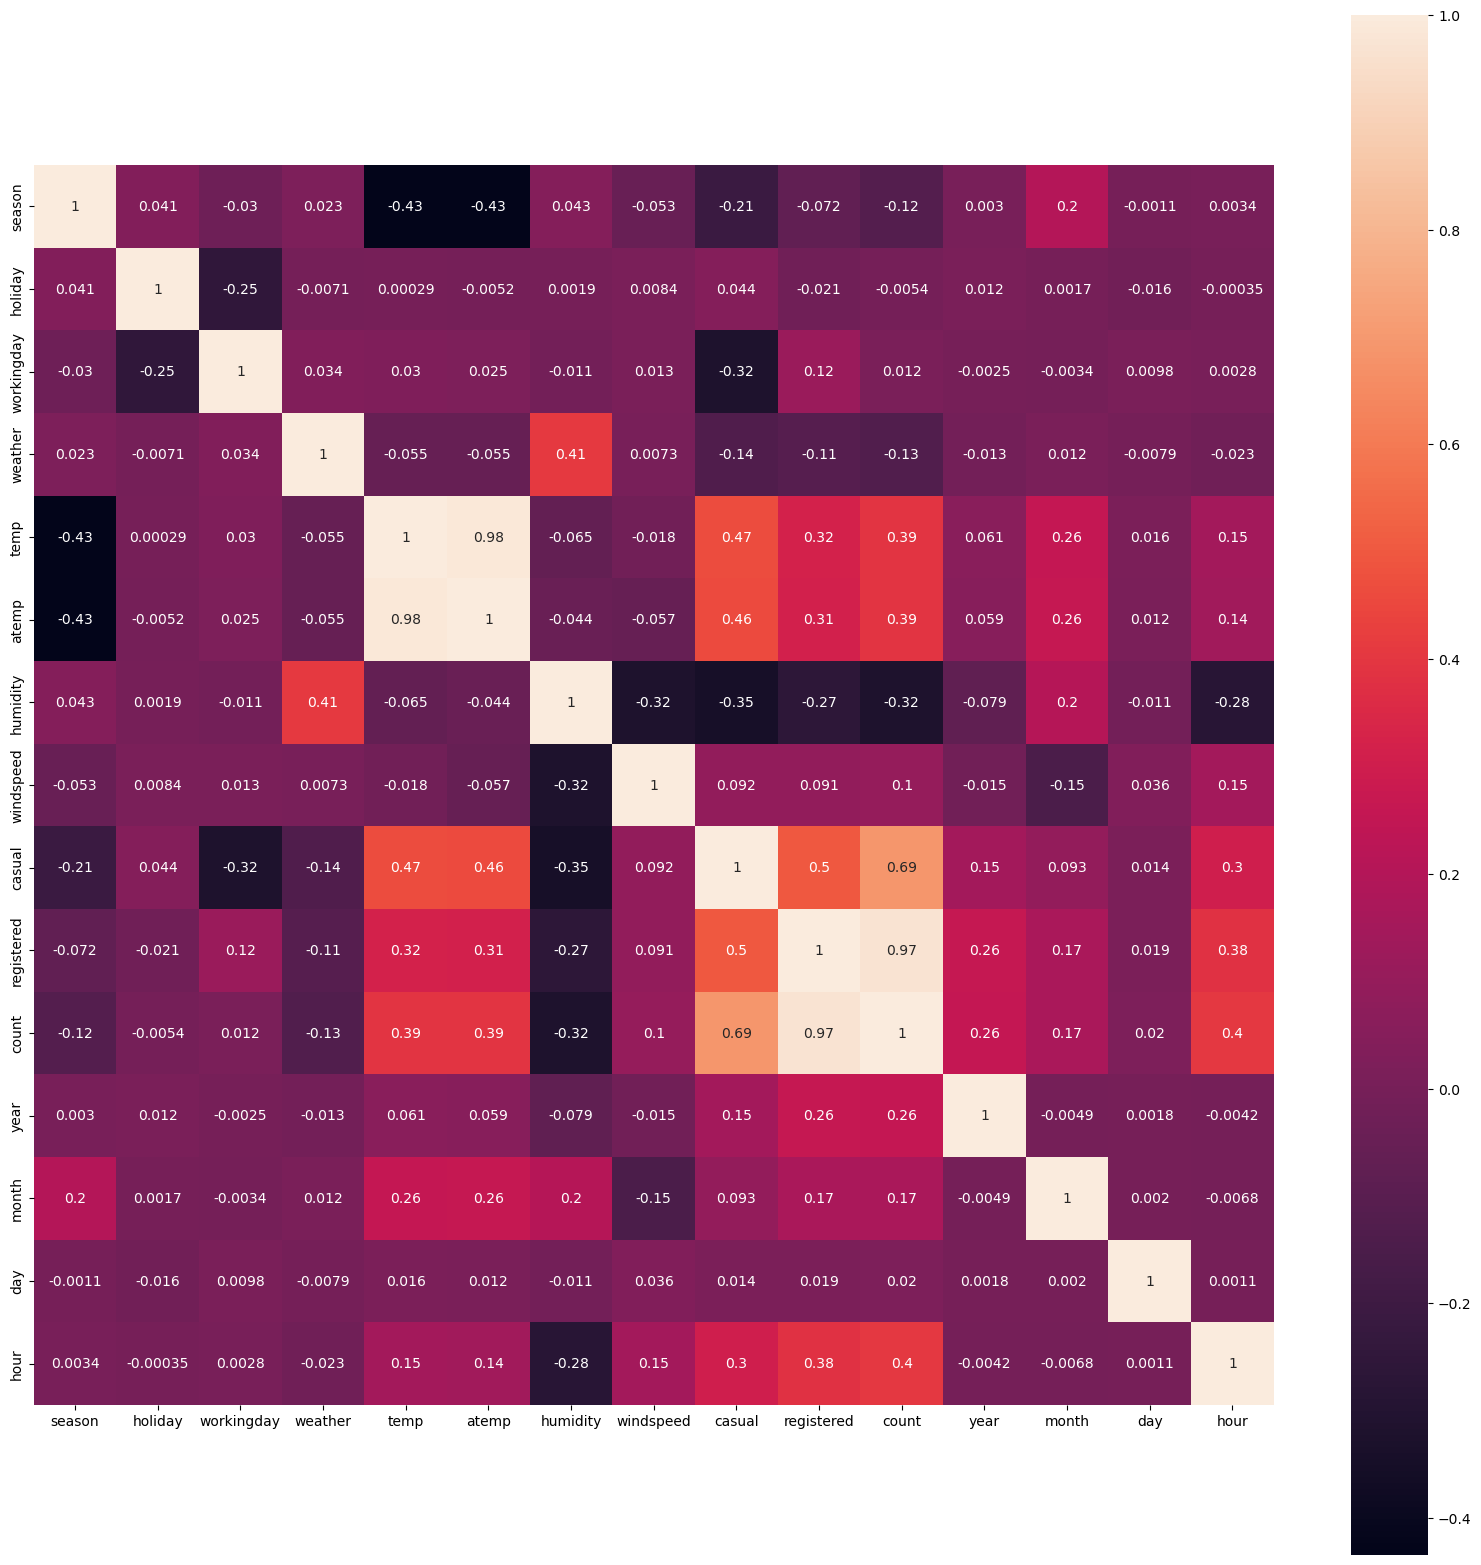

In [141]:
fig = plt.figure(figsize=[20,20])# 도화지 설정
sns.heatmap(train.corr(),annot=True,square=True)#정사각형 설정
# sns.heatmap(train.corr(method = 'spearman'),annot=True,square=True)# 여담으로 스피어만, 켄달도 확인해보자.

In [142]:
#count와 관련이 된 곳이 온도와 체감온도, 캐주얼과 레지스터는 합쳐서 카운트기에 의미없다. 실제 모델만들때는 두 개를 빼야한다.
# 온도와 체감온도가 동일하다. 이러한 것을 "공성성"이라고 한다. 실질적으로 동일한 수치라는 뜻이다. 
# 날씨, 습도, 시간등이 영향을 크게 주는것 같다. 
# 하지만 분명히 다른 것은 영향을 주겠지만 피어슨 상관계수로 안나오는 것일 가능성도 고려해야 한다. 
# 값이 상관성이 없어보이는 것이 많이 존재한다. 만약 선형이 아닌 경우 비선형(피어슨이 아닌 스피어만 상관계수)으로 확인하자.

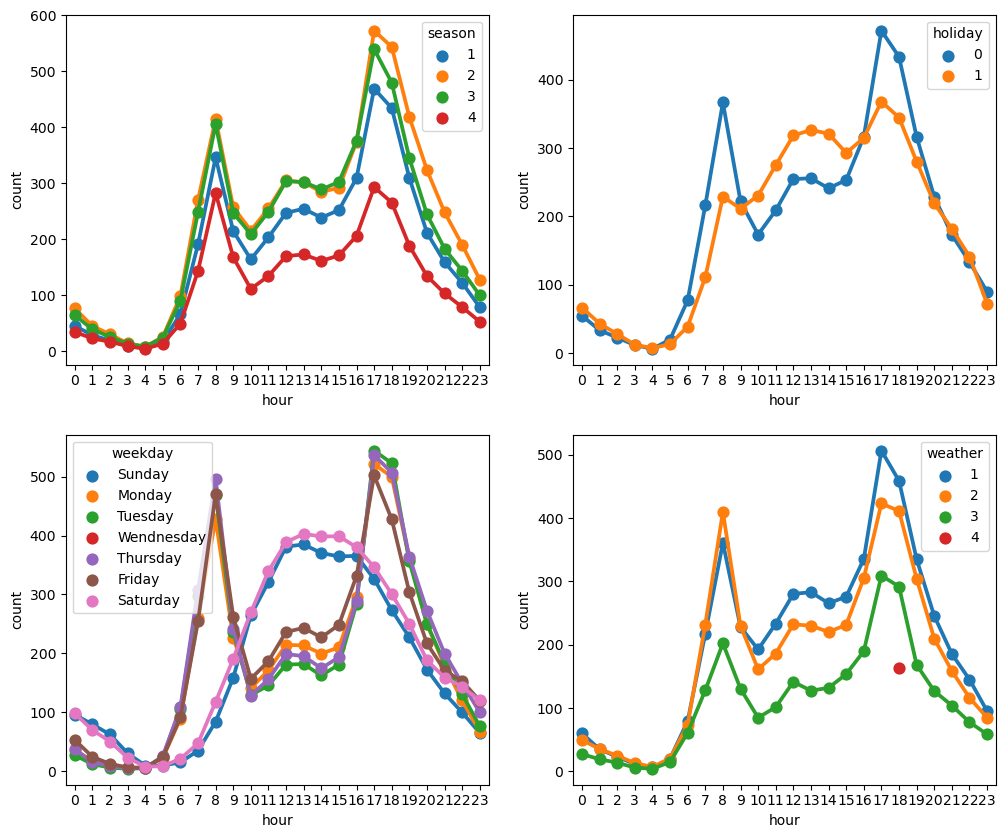

In [143]:
#시간과 계절에 따른 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.pointplot(x='hour',y='count',hue='season',data=train.groupby(['season','hour'])['count'].mean().reset_index())
# 출퇴근 시즌에 몰려있는 것을 볼 수 있다. 

#시간과 휴일 여부에 따른 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.pointplot(x='hour',y='count',hue='holiday',data=train.groupby(['holiday','hour'])['count'].mean().reset_index())
# 휴일이 아니면 출퇴근시간, 휴일이면 일정하게 상승하는 모양새를 보인다.

#시간과 휴일 여부에 따른 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.pointplot(x='hour',y='count',hue='weekday',hue_order=['Sunday','Monday','Tuesday','Wendnesday','Thursday','Friday','Saturday'],data=train.groupby(['weekday','hour'])['count'].mean().reset_index())
# 토요일과 일요일은 주로 점심때에 집중되어있다. 

#시간과 날씨에 따른 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.pointplot(x='hour',y='count',hue='weather',data=train.groupby(['weather','hour'])['count'].mean().reset_index())
# 날씨에 따른 이용빈도인데 4는 점 하나만 나왔다. 폭우, 얼음팔레트. 뇌우였다. 1건만 있다. 오히려 4를 빼는게 나을 듯 하다. 
# 만약 변경한다면 한쪽만 하는게 아니라 테스트 데이터도 변경해야 한다. 

In [144]:
train[train.weather==4] # 단 한건만 존재한다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
5631,2012-01-09 18:00:00,4,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,9,18,Monday


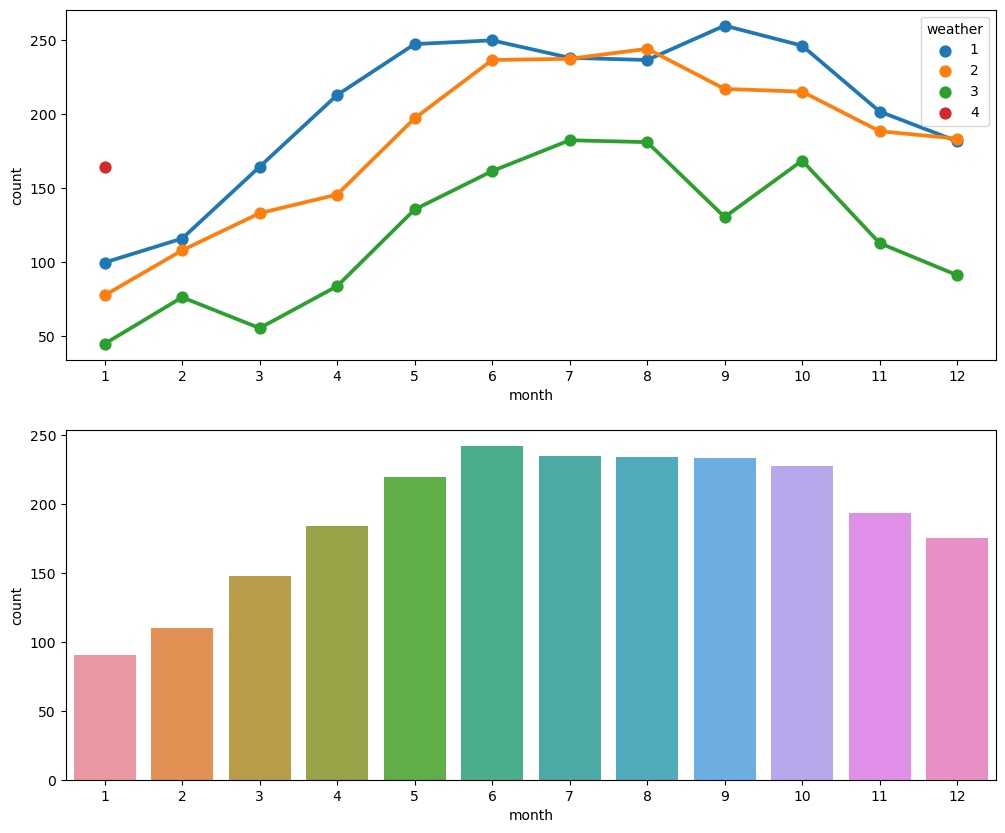

In [145]:
# 월별로 카운트를 출력해보자. 
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,1,1)
ax1 = sns.pointplot(x='month',y='count',hue='weather',data=train.groupby(['weather','month'])['count'].mean().reset_index())
# 날씨와 달을 비교해봤다. 

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())

In [146]:
# 함수를 써서 채워도 되긴 하지만 귀찮다. 머신러닝을 쓰는 것이 나을 듯 하다. 
train.info() #weekday는 문자열이다. 카테고리 타입으로 바꿔보자.. 카테고리 하나가 클래스가 되는 것이다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  year        10886 non-null  int64  
 13  month       10886 non-null  int64  
 14  day         10886 non-null  int64  
 15  hour        10886 non-null  int64  
 16  weekday     10886 non-null  object 
dtypes: float64(3), int64(12), object(2)
memory usage: 1.4+ MB


In [152]:
train['weekday'] = train.weekday.astype('category')
train['weekday'] # 이제 요일데이터는 카테고리이다. 


0         Saturday
1         Saturday
2         Saturday
3         Saturday
4         Saturday
           ...    
10881    Wednesday
10882    Wednesday
10883    Wednesday
10884    Wednesday
10885    Wednesday
Name: weekday, Length: 10886, dtype: category
Categories (7, object): ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [153]:
train['weekday'].cat.categories=['5','1','6','0','4','2','3']

C:\Users\user\AppData\Local\Temp\ipykernel_3040\3374369094.py:1: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  train['weekday'].cat.categories=['5','1','6','0','4','2','3']


In [154]:
train['weekday']# 0부터 6까지 이루어진 카테고리가 완성되었다. 

0        6
1        6
2        6
3        6
4        6
        ..
10881    3
10882    3
10883    3
10884    3
10885    3
Name: weekday, Length: 10886, dtype: category
Categories (7, object): ['5', '1', '6', '0', '4', '2', '3']

In [162]:
# 랜덤 포레스트를 통해 풍량칸의 결측값을 채워보자. 
# 풍량이 갑자기 0으로 바뀐다. 결측값이 많다. 
# 사실 위와 아래의 평균을 구하는 복안법을 사용할 수 있다. 
# 또는 가장 비슷한 수치의 다른 곳의 값을 채우는 방법이 있다. 
# 지구가 자전을 하는데 량이 풍0이 되기가 힘들 것이다. 
# 또는 6.0032가 많다. 즉 구간을 나눠서 대입한 것이다. 
# 이 대회의 핵심은 풍량을 어떻게 채웠느냐였다. 
# 풍속이 0이 아닌 값들로 구성된 데이터프레임을 만들어서 풍속 예측 모델을 생성하는 것이 목표이다.
# 풍속이 0인 값들로 구성된 데이터프레임에 대한 풍속을 계측하여 값을 저장한다. 

In [163]:
from sklearn.ensemble import RandomForestRegressor # 연속형 값을 구하는 것이기 때문에 regressor를 써야한다. 

In [164]:
windspeed_0 = train[train.windspeed==0]
windspeed_not0 = train[train.windspeed!=0]
windspeed_0 #일단 풍량예측 모델이기 때문에 빠져야할 대상을 찾아봐야 한다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,6
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,6
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,6
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,6
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,0.0,21,211,232,2012,12,17,12,1
10829,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,0.0,15,196,211,2012,12,17,15,1
10846,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,0.0,10,652,662,2012,12,18,8,2
10860,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,0.0,5,127,132,2012,12,18,22,2


In [165]:
windspeed_not0

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
5,2011-01-01 05:00:00,4,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,6
10,2011-01-01 10:00:00,4,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,6
11,2011-01-01 11:00:00,4,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,6
12,2011-01-01 12:00:00,4,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011,1,1,12,6
13,2011-01-01 13:00:00,4,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011,1,1,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,3
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,3
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,3
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,3


In [166]:
windspeed_0df = windspeed_0.drop(['datetime','windspeed','casual','registered','count','workingday',"holiday","day",'weekday'],axis=1)
windspeed_0df # 이거가지고 만들어야 한다. 

,season,weather,temp,atemp,humidity,year,month,hour
0,4,1,9.84,14.395,81,2011,1,0
1,4,1,9.02,13.635,80,2011,1,1
2,4,1,9.02,13.635,80,2011,1,2
3,4,1,9.84,14.395,75,2011,1,3
4,4,1,9.84,14.395,75,2011,1,4
...,...,...,...,...,...,...,...,...
10826,4,2,16.40,20.455,87,2012,12,12
10829,4,2,17.22,21.210,88,2012,12,15
10846,4,1,15.58,19.695,94,2012,12,8
10860,4,1,13.94,16.665,49,2012,12,22


In [167]:
windspeed_not0df = windspeed_not0.drop(['datetime','windspeed','casual','registered','count','workingday',"holiday","day",'weekday'],axis=1)
windspeed_not0df # 이걸 타겟 x로 잡아놓자. y는 풍속으로 따로 추출하자. 
# 여기에 대한 표준화, 정규화도 필요할 수 있다. 

,season,weather,temp,atemp,humidity,year,month,hour
5,4,2,9.84,12.880,75,2011,1,5
10,4,1,15.58,19.695,76,2011,1,10
11,4,1,14.76,16.665,81,2011,1,11
12,4,1,17.22,21.210,77,2011,1,12
13,4,2,18.86,22.725,72,2011,1,13
...,...,...,...,...,...,...,...,...
10881,4,1,15.58,19.695,50,2012,12,19
10882,4,1,14.76,17.425,57,2012,12,20
10883,4,1,13.94,15.910,61,2012,12,21
10884,4,1,13.94,17.425,61,2012,12,22


In [168]:
windspeed_not0_series = windspeed_not0['windspeed']
windspeed_not0_series # 답지를 따로 만들었다. 

5         6.0032
10       16.9979
11       19.0012
12       19.0012
13       19.9995
          ...   
10881    26.0027
10882    15.0013
10883    15.0013
10884     6.0032
10885     8.9981
Name: windspeed, Length: 9573, dtype: float64

In [170]:
windspeed_not0df # 이렇게 준비되었다. 

,season,weather,temp,atemp,humidity,year,month,hour
5,4,2,9.84,12.880,75,2011,1,5
10,4,1,15.58,19.695,76,2011,1,10
11,4,1,14.76,16.665,81,2011,1,11
12,4,1,17.22,21.210,77,2011,1,12
13,4,2,18.86,22.725,72,2011,1,13
...,...,...,...,...,...,...,...,...
10881,4,1,15.58,19.695,50,2012,12,19
10882,4,1,14.76,17.425,57,2012,12,20
10883,4,1,13.94,15.910,61,2012,12,21
10884,4,1,13.94,17.425,61,2012,12,22


In [171]:
rf = RandomForestRegressor()

In [172]:
rf.fit(windspeed_not0df,windspeed_not0_series)# 모델이 만들어졌다. 

RandomForestRegressor()

In [174]:
windspeed_0['windspeed']= rf.predict(windspeed_0df)
windspeed_0 # 풍향값을 대입했다. 

C:\Users\user\AppData\Local\Temp\ipykernel_3040\132117195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windspeed_0['windspeed']= rf.predict(windspeed_0df)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,8.172291,3,13,16,2011,1,1,0,6
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,8.392286,8,32,40,2011,1,1,1,6
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,8.372387,5,27,32,2011,1,1,2,6
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,6.809232,3,10,13,2011,1,1,3,6
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,6.691798,0,1,1,2011,1,1,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,14.690640,21,211,232,2012,12,17,12,1
10829,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,11.372941,15,196,211,2012,12,17,15,1
10846,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,8.631007,10,652,662,2012,12,18,8,2
10860,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,12.068509,5,127,132,2012,12,18,22,2


In [176]:
train = pd.concat([windspeed_0,windspeed_not0],axis=0)
train # 이렇게 합쳐졌다. 
# 다른 데이터를 쓸 때에도 가장 유사한 데이터를 찾아서 예측이 가능하도록 해주자. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,8.172291,3,13,16,2011,1,1,0,6
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,8.392286,8,32,40,2011,1,1,1,6
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,8.372387,5,27,32,2011,1,1,2,6
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,6.809232,3,10,13,2011,1,1,3,6
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,6.691798,0,1,1,2011,1,1,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336,2012,12,19,19,3
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241,2012,12,19,20,3
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168,2012,12,19,21,3
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,117,129,2012,12,19,22,3


In [177]:
train.info()# 문제는 이거 아직 오브젝트다. 날짜 데이터다 아직 안바뀌었다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season      10886 non-null  int64   
 2   holiday     10886 non-null  int64   
 3   workingday  10886 non-null  int64   
 4   weather     10886 non-null  int64   
 5   temp        10886 non-null  float64 
 6   atemp       10886 non-null  float64 
 7   humidity    10886 non-null  int64   
 8   windspeed   10886 non-null  float64 
 9   casual      10886 non-null  int64   
 10  registered  10886 non-null  int64   
 11  count       10886 non-null  int64   
 12  year        10886 non-null  int64   
 13  month       10886 non-null  int64   
 14  day         10886 non-null  int64   
 15  hour        10886 non-null  int64   
 16  weekday     10886 non-null  category
dtypes: category(1), float64(3), int64(12), object(1)
memory usage: 1.4+ MB


In [178]:
train.datetime # 시간을 기준으로 오름차순 정렬을 하고싶다고 해보자. 
# 날짜데이터가 뒤죽박죽 섞여있을 수 있다. 날짜형식으로 바꾸소 sort를 하자. 

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [181]:
train.datetime = pd.to_datetime(train.datetime) # 이렇게 날짜형식으로 변경했다.
train.datetime

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [183]:
# 정렬은 소트벨류를 쓰자.
train.sort_values(['datetime'])
# 내림차순 정렬은 이렇게 한다. train.sort_values(['datetime'],ascending=False) # 이와같은 방식으로 간단하게 해결이 가능하다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,8.172291,3,13,16,2011,1,1,0,6
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,8.392286,8,32,40,2011,1,1,1,6
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,8.372387,5,27,32,2011,1,1,2,6
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,6.809232,3,10,13,2011,1,1,3,6
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,6.691798,0,1,1,2011,1,1,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336,2012,12,19,19,3
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241,2012,12,19,20,3
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168,2012,12,19,21,3
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,117,129,2012,12,19,22,3


C:\Users\user\AppData\Local\Temp\ipykernel_3040\1698534930.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,square=True)#정사각형 설정


<Axes: >

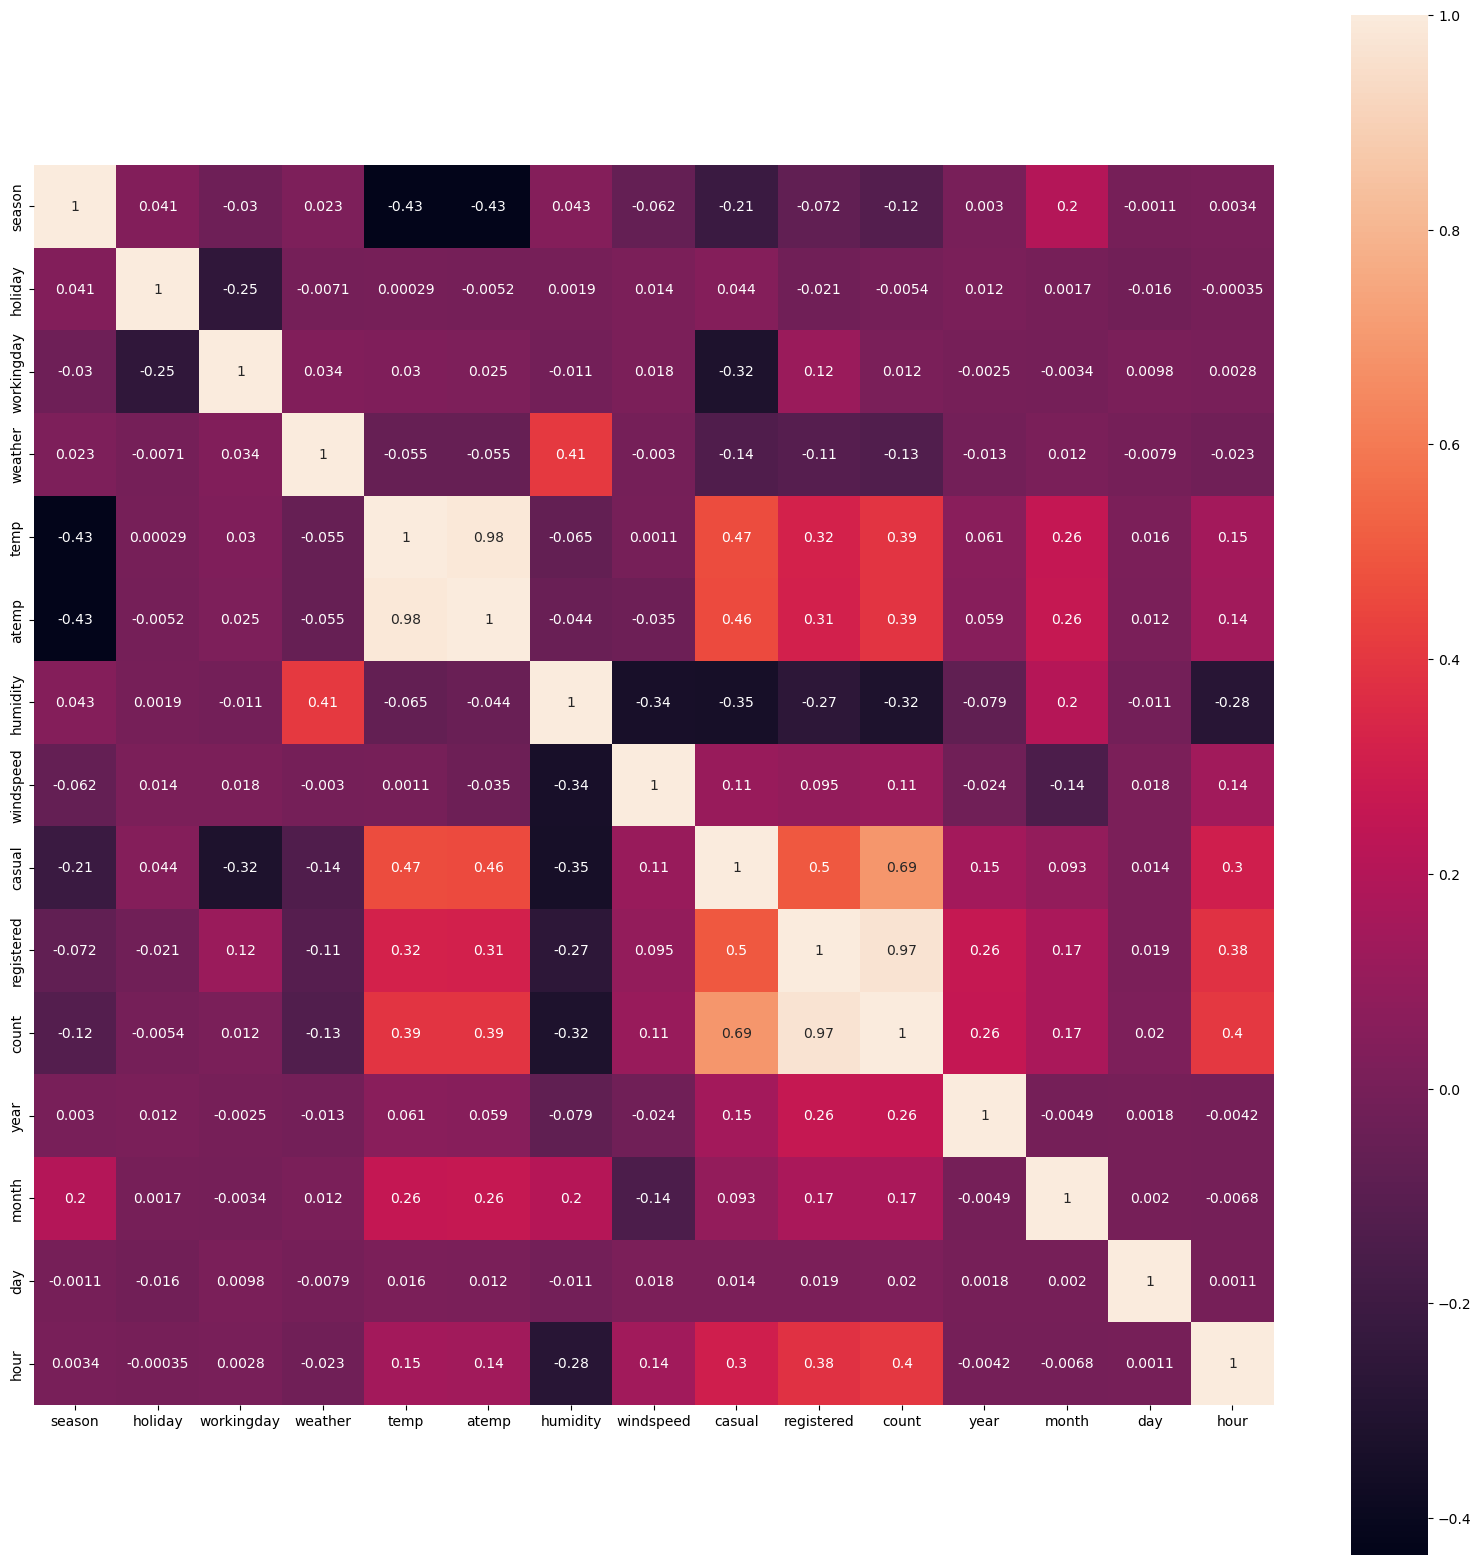

In [184]:
fig = plt.figure(figsize=[20,20])# 도화지 설정
sns.heatmap(train.corr(),annot=True,square=True)#정사각형 설정
# 거의 변화는 없다. 미세하게 상관관계가 있다. 

C:\Users\user\AppData\Local\Temp\ipykernel_3040\2056900985.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.windspeed,bins=range(int(train.windspeed.min()),int(train.windspeed.max())+1))


<Axes: xlabel='windspeed', ylabel='Density'>

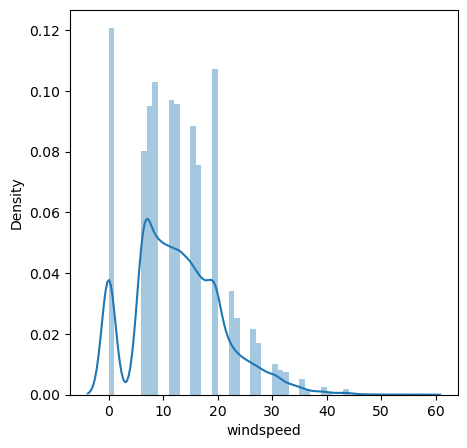

In [236]:
plt.figure(figsize=[5,5])
sns.distplot(train.windspeed,bins=range(int(train.windspeed.min()),int(train.windspeed.max())+1))
# 이제 0에 해당하는 값은 존재하지 않는다. 
# 

In [237]:
# 그레디언트 부스팅을 이용해서 작업을 할 것이다. 일단 일치시켜보자. 
train=pd.read_csv("bike-sharing-demand/train.csv")
test=pd.read_csv("bike-sharing-demand/test.csv")
combine = pd.concat([train,test],axis=0) # 콤바인으로 설정하고 합쳐보자.
combine

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [238]:
combine['tempDate'] = combine.datetime.apply(lambda x:x.split()) 
combine['weekday'] = combine.tempDate.apply(lambda x: calendar.day_name[datetime.strptime(x[0],"%Y-%m-%d").weekday()])
combine['year'] = combine.tempDate.apply(lambda x: x[0].split('-')[0])
combine['month'] = combine.tempDate.apply(lambda x: x[0].split('-')[1])
combine['day'] = combine.tempDate.apply(lambda x: x[0].split('-')[2])
combine['hour'] = combine.tempDate.apply(lambda x: x[1].split(':')[0])
# 아까 했던 데이터 변화작업이다. 



In [239]:
combine['year'] = pd.to_numeric(combine.year)
combine['month'] = pd.to_numeric(combine.month)
combine['day'] = pd.to_numeric(combine.day)
combine['hour'] = pd.to_numeric(combine.hour)

In [240]:
combine['season']=combine.month.apply(newSeason)

In [241]:
combine.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempDate,weekday,year,month,day,hour
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,"[2011-01-01, 00:00:00]",Saturday,2011,1,1,0
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,"[2011-01-01, 01:00:00]",Saturday,2011,1,1,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,"[2011-01-01, 02:00:00]",Saturday,2011,1,1,2
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,"[2011-01-01, 03:00:00]",Saturday,2011,1,1,3
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,"[2011-01-01, 04:00:00]",Saturday,2011,1,1,4


In [242]:
combine.weekday = combine.weekday.astype('category')

In [243]:
combine.weekday.cat.categories = ['5','1','6','0','4','2','3']

C:\Users\user\AppData\Local\Temp\ipykernel_3040\3864947247.py:1: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  combine.weekday.cat.categories = ['5','1','6','0','4','2','3']


In [244]:
dataWind0 = combine[combine['windspeed']==0]
dataWindNot0 = combine[combine['windspeed']!=0]

In [245]:
dataWind0.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'tempDate', 'weekday', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [246]:
dataWind0_df=dataWind0.drop(['datetime','windspeed','casual', 'registered','count', 'holiday', 'workingday', 'day', 'weekday','tempDate'], axis=1)
dataWindNot0_df=dataWindNot0.drop(['datetime','windspeed','casual', 'registered','count', 'holiday', 'workingday', 'day', 'weekday','tempDate'], axis=1)

In [247]:
dataWindNot0_series = dataWindNot0['windspeed']
dataWindNot0_df

,season,weather,temp,atemp,humidity,year,month,hour
5,4,2,9.84,12.880,75,2011,1,5
10,4,1,15.58,19.695,76,2011,1,10
11,4,1,14.76,16.665,81,2011,1,11
12,4,1,17.22,21.210,77,2011,1,12
13,4,2,18.86,22.725,72,2011,1,13
...,...,...,...,...,...,...,...,...
6488,4,2,10.66,12.880,60,2012,12,19
6489,4,2,10.66,12.880,60,2012,12,20
6490,4,1,10.66,12.880,60,2012,12,21
6491,4,1,10.66,13.635,56,2012,12,22


In [248]:
rf2 = RandomForestRegressor()

In [249]:
rf2.fit(dataWindNot0_df,dataWindNot0_series)

RandomForestRegressor()

In [250]:
pred = rf2.predict(dataWind0_df)
pred

array([ 7.07829157,  6.662614  ,  6.5526    , ...,  8.341567  ,
       23.76021   ,  7.760945  ])

In [251]:
dataWind0['windspeed'] = pred # 아까 했던거 그대로 했다. 
dataWind0

C:\Users\user\AppData\Local\Temp\ipykernel_3040\84679004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0['windspeed'] = pred # 아까 했던거 그대로 했다.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempDate,weekday,year,month,day,hour
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,7.078292,3.0,13.0,16.0,"[2011-01-01, 00:00:00]",6,2011,1,1,0
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,6.662614,8.0,32.0,40.0,"[2011-01-01, 01:00:00]",6,2011,1,1,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,6.552600,5.0,27.0,32.0,"[2011-01-01, 02:00:00]",6,2011,1,1,2
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,6.645857,3.0,10.0,13.0,"[2011-01-01, 03:00:00]",6,2011,1,1,3
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,6.505961,0.0,1.0,1.0,"[2011-01-01, 04:00:00]",6,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,2012-12-29 12:00:00,4,0,0,3,8.20,12.120,100,8.242206,NaN,NaN,NaN,"[2012-12-29, 12:00:00]",6,2012,12,29,12
6434,2012-12-29 13:00:00,4,0,0,3,8.20,12.120,100,8.262038,NaN,NaN,NaN,"[2012-12-29, 13:00:00]",6,2012,12,29,13
6436,2012-12-29 15:00:00,4,0,0,2,9.84,12.120,87,8.341567,NaN,NaN,NaN,"[2012-12-29, 15:00:00]",6,2012,12,29,15
6444,2012-12-29 23:00:00,4,0,0,2,10.66,12.120,60,23.760210,NaN,NaN,NaN,"[2012-12-29, 23:00:00]",6,2012,12,29,23


In [254]:
combine = pd.concat([dataWindNot0,dataWind0],axis=0)
combine
# 범주형으로 나눠야 할 것은 계절, 날씨,요일,month,day등이 있다. tempdate는 버려야 할 것이다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempDate,weekday,year,month,day,hour
5,2011-01-01 05:00:00,4,0,0,2,9.84,12.880,75,6.003200,0.0,1.0,1.0,"[2011-01-01, 05:00:00]",6,2011,1,1,5
10,2011-01-01 10:00:00,4,0,0,1,15.58,19.695,76,16.997900,12.0,24.0,36.0,"[2011-01-01, 10:00:00]",6,2011,1,1,10
11,2011-01-01 11:00:00,4,0,0,1,14.76,16.665,81,19.001200,26.0,30.0,56.0,"[2011-01-01, 11:00:00]",6,2011,1,1,11
12,2011-01-01 12:00:00,4,0,0,1,17.22,21.210,77,19.001200,29.0,55.0,84.0,"[2011-01-01, 12:00:00]",6,2011,1,1,12
13,2011-01-01 13:00:00,4,0,0,2,18.86,22.725,72,19.999500,47.0,47.0,94.0,"[2011-01-01, 13:00:00]",6,2011,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,2012-12-29 12:00:00,4,0,0,3,8.20,12.120,100,8.242206,NaN,NaN,NaN,"[2012-12-29, 12:00:00]",6,2012,12,29,12
6434,2012-12-29 13:00:00,4,0,0,3,8.20,12.120,100,8.262038,NaN,NaN,NaN,"[2012-12-29, 13:00:00]",6,2012,12,29,13
6436,2012-12-29 15:00:00,4,0,0,2,9.84,12.120,87,8.341567,NaN,NaN,NaN,"[2012-12-29, 15:00:00]",6,2012,12,29,15
6444,2012-12-29 23:00:00,4,0,0,2,10.66,12.120,60,23.760210,NaN,NaN,NaN,"[2012-12-29, 23:00:00]",6,2012,12,29,23


In [257]:
combine['season'].astype('category') # 범주형으로 바꾸는 것은 이렇게 하자. 
# 카테고리 타입은 종류별로 나눈 타입이다. 그리고 순서가 존재한다. 
# 혈액형은 순서가 없다. 순서가 있는 것과 없는 것을 나눠야 하는데 카테고리를 만들면 순서가 만들어진다. 종류간에 순서가 있다고 해석하면 된다.

5       4
10      4
11      4
12      4
13      4
       ..
6433    4
6434    4
6436    4
6444    4
6464    4
Name: season, Length: 17379, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [258]:
pd.get_dummies(combine['season'])# 원핫인코딩으로 처리했다. 

,1,2,3,4
5,0,0,0,1
10,0,0,0,1
11,0,0,0,1
12,0,0,0,1
13,0,0,0,1
...,...,...,...,...
6433,0,0,0,1
6434,0,0,0,1
6436,0,0,0,1
6444,0,0,0,1


In [259]:
# 데이터타입은 수치형과 범주형으로 나뉜다. 
# 수치형은 연속형(실수형도 포함)과 이산형(정수로 딱 끊어지는거)으로 나눠진다. 
# 범주형(여러개로 나뉜값)은 명목형(순서가 없는종류들)과 순서형(순서가 있음)이 존재한다. 
# get_dummies는 범주형으로 나타내겠다는 이야기이다. 
# 방금의 계절도 1,2,3,4로 나눠졌지만 사실 계절은 범주형에 가깝다. 
# 카테고리를 쓰는 이유도 같다. 카테고리는 종류를 나타낸다. 범주인 것이다. 
# 종류가 여러가지일 경우에는 범주형으로 나눌 경우에 좋은 성능을 발휘한다. 
# 범주화는 차원을 증가시키는 것이다. 성능을 증가시킬 목적의 차원증기이다.

In [260]:
combine.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'tempDate', 'weekday', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [261]:
# 제거열을 분류해보자. 
cate_cols=['season', 'weather','weekday', 'year', 'month', 'hour']
drop_cols=['datetime','casual', 'registered', 'count','tempDate', 'day']

In [262]:
for col in cate_cols:
    combine[col] = combine[col].astype('category')

In [263]:
combine.info() # 카테고리를 전부 적용했다. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 5 to 6464
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    17379 non-null  object  
 1   season      17379 non-null  category
 2   holiday     17379 non-null  int64   
 3   workingday  17379 non-null  int64   
 4   weather     17379 non-null  category
 5   temp        17379 non-null  float64 
 6   atemp       17379 non-null  float64 
 7   humidity    17379 non-null  int64   
 8   windspeed   17379 non-null  float64 
 9   casual      10886 non-null  float64 
 10  registered  10886 non-null  float64 
 11  count       10886 non-null  float64 
 12  tempDate    17379 non-null  object  
 13  weekday     17379 non-null  category
 14  year        17379 non-null  category
 15  month       17379 non-null  category
 16  day         17379 non-null  int64   
 17  hour        17379 non-null  category
dtypes: category(6), float64(6), int64(4), object(2)

In [264]:
# 이제 훈련데이터와 테스트 데이터를 분리해보자.
train = combine[pd.notnull(combine['count'])].sort_values('datetime')
train # 즉 불린함수로 정답이 적혀있는 곳을 따로 추출한 것이다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempDate,weekday,year,month,day,hour
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,7.078292,3.0,13.0,16.0,"[2011-01-01, 00:00:00]",6,2011,1,1,0
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,6.662614,8.0,32.0,40.0,"[2011-01-01, 01:00:00]",6,2011,1,1,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,6.552600,5.0,27.0,32.0,"[2011-01-01, 02:00:00]",6,2011,1,1,2
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,6.645857,3.0,10.0,13.0,"[2011-01-01, 03:00:00]",6,2011,1,1,3
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,6.505961,0.0,1.0,1.0,"[2011-01-01, 04:00:00]",6,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7.0,329.0,336.0,"[2012-12-19, 19:00:00]",3,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10.0,231.0,241.0,"[2012-12-19, 20:00:00]",3,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4.0,164.0,168.0,"[2012-12-19, 21:00:00]",3,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12.0,117.0,129.0,"[2012-12-19, 22:00:00]",3,2012,12,19,22


In [265]:
test = combine[pd.isnull(combine['count'])].sort_values('datetime')
test # 불린함수로 nan값이 있는 것만 추출되었다. 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,tempDate,weekday,year,month,day,hour
0,2011-01-20 00:00:00,4,0,1,1,10.66,11.365,56,26.002700,NaN,NaN,NaN,"[2011-01-20, 00:00:00]",4,2011,1,20,0
1,2011-01-20 01:00:00,4,0,1,1,10.66,13.635,56,8.678979,NaN,NaN,NaN,"[2011-01-20, 01:00:00]",4,2011,1,20,1
2,2011-01-20 02:00:00,4,0,1,1,10.66,13.635,56,8.589400,NaN,NaN,NaN,"[2011-01-20, 02:00:00]",4,2011,1,20,2
3,2011-01-20 03:00:00,4,0,1,1,10.66,12.880,56,11.001400,NaN,NaN,NaN,"[2011-01-20, 03:00:00]",4,2011,1,20,3
4,2011-01-20 04:00:00,4,0,1,1,10.66,12.880,56,11.001400,NaN,NaN,NaN,"[2011-01-20, 04:00:00]",4,2011,1,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,4,0,1,2,10.66,12.880,60,11.001400,NaN,NaN,NaN,"[2012-12-31, 19:00:00]",1,2012,12,31,19
6489,2012-12-31 20:00:00,4,0,1,2,10.66,12.880,60,11.001400,NaN,NaN,NaN,"[2012-12-31, 20:00:00]",1,2012,12,31,20
6490,2012-12-31 21:00:00,4,0,1,1,10.66,12.880,60,11.001400,NaN,NaN,NaN,"[2012-12-31, 21:00:00]",1,2012,12,31,21
6491,2012-12-31 22:00:00,4,0,1,1,10.66,13.635,56,8.998100,NaN,NaN,NaN,"[2012-12-31, 22:00:00]",1,2012,12,31,22


In [266]:
# 이제 프레임 드랍을 하자.
train = train.drop(drop_cols,axis=1)
test = test.drop(drop_cols,axis=1)

In [274]:
train # 잘 나왔다. 12개 열이 나왔다. 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,year,month,hour
0,4,0,0,1,9.84,14.395,81,7.078292,6,2011,1,0
1,4,0,0,1,9.02,13.635,80,6.662614,6,2011,1,1
2,4,0,0,1,9.02,13.635,80,6.552600,6,2011,1,2
3,4,0,0,1,9.84,14.395,75,6.645857,6,2011,1,3
4,4,0,0,1,9.84,14.395,75,6.505961,6,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.002700,3,2012,12,19
10882,4,0,1,1,14.76,17.425,57,15.001300,3,2012,12,20
10883,4,0,1,1,13.94,15.910,61,15.001300,3,2012,12,21
10884,4,0,1,1,13.94,17.425,61,6.003200,3,2012,12,22


In [273]:
test # 여기도 12개 열이 잘 나온 상태이다. 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,year,month,hour
0,4,0,1,1,10.66,11.365,56,26.002700,4,2011,1,0
1,4,0,1,1,10.66,13.635,56,8.678979,4,2011,1,1
2,4,0,1,1,10.66,13.635,56,8.589400,4,2011,1,2
3,4,0,1,1,10.66,12.880,56,11.001400,4,2011,1,3
4,4,0,1,1,10.66,12.880,56,11.001400,4,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,4,0,1,2,10.66,12.880,60,11.001400,1,2012,12,19
6489,4,0,1,2,10.66,12.880,60,11.001400,1,2012,12,20
6490,4,0,1,1,10.66,12.880,60,11.001400,1,2012,12,21
6491,4,0,1,1,10.66,13.635,56,8.998100,1,2012,12,22


In [353]:
train2 = pd.read_csv("bike-sharing-demand/train.csv")
ylabel = train2['count'] 
ylabel = ylabel.astype("float64")
ylabel 

0         16.0
1         40.0
2         32.0
3         13.0
4          1.0
         ...  
10881    336.0
10882    241.0
10883    168.0
10884    129.0
10885     88.0
Name: count, Length: 10886, dtype: float64

In [354]:
from sklearn.model_selection import GridSearchCV # 성능테스트를 해보자. 
from sklearn import metrics

In [397]:
rf = RandomForestRegressor(n_estimators=100)
# 예측값들이 나와서 평균을 낸다. 리그레서는 평균을 낸다. 

In [412]:
grid_cf = GridSearchCV(rf,rf_params,scoring='neg_mean_poisson_deviance',cv=5) # 점수계산을 설정한다. . 폴드는 5이다. 

In [413]:
grid_cf.fit(train, ylabel)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [30, 50, 70, 100]},
             scoring='neg_mean_poisson_deviance')

In [414]:
submission = pd.read_csv("bike-sharing-demand/sampleSubmission.csv")
submission
answer2 = grid_cf.predict(test)
submission['count'] = answer2

In [415]:
submission.to_csv("bikesubmission.csv",index = False)